### Binary Classification Model for Kaggle Tabular Playground Series November 2021 Using TensorFlow Decision Forests
### David Lowe
### December 9, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground November 2021 dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset used for this competition is synthetic but based on a real dataset and generated using a CTGAN. The data is synthetically generated by a GAN trained on a real-world dataset used to identify spam emails via various extracted features from the email. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS: The performance of the preliminary Random Forest model achieved a ROC/AUC benchmark of 0.7166 on the validation dataset. The final model processed the validation dataset with a final ROC/AUC score of 0.7306. When we applied the finalized model to Kaggle's test dataset, the model achieved a ROC/AUC score of 0.7387.

CONCLUSION: In this iteration, the TensorFlow Decision Forests model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 November Data Set

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-nov-2021

One potential source of performance benchmark: https://www.kaggle.com/c/tabular-playground-series-nov-2021/leaderboard

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL boto3
# !pip install tensorflow_decision_forests

In [2]:
!pip install wurlitzer

In [3]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
import boto3
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
import tensorflow_decision_forests as tfdf

2021-12-02 22:36:43.104770: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-02 22:36:43.104845: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = True

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.1

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = ["accuracy", tf.keras.metrics.AUC()]

# Define the directory locations and file names
TRAIN_DATASET = 'train.csv'
TEST_DATASET = 'test.csv'

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow version: 2.7.0
Found TensorFlow Decision Forests v0.2.1


2021-12-02 22:37:13.707166: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-02 22:37:13.707238: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-02 22:37:13.707293: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (54d411fd1deb): /proc/driver/nvidia/version does not exist


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [10]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [11]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021nov/train.csv

--2021-12-02 22:37:43--  https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021nov/train.csv
Resolving dainesanalytics.com (dainesanalytics.com)... 13.226.228.58, 13.226.228.127, 13.226.228.118, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.226.228.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 545645113 (520M) [text/csv]
Saving to: ‘train.csv’

train.csv           100%[===================>] 520.37M  3.17MB/s    in 3m 38s  

2021-12-02 22:41:22 (2.39 MB/s) - ‘train.csv’ saved [545645113/545645113]



In [12]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id        f0       f1        f2       f3        f4       f5       f6  \
0   0  0.106643  3.59437  132.8040  3.18428  0.081971  1.18859  3.73238   
1   1  0.125021  1.67336   76.5336  3.37825  0.099400  5.09366  1.27562   
2   2  0.036330  1.49747  233.5460  2.19435  0.026914  3.12694  5.05687   
3   3 -0.014077  0.24600  779.9670  1.89064  0.006948  1.53112  2.69800   
4   4 -0.003259  3.71542  156.1280  2.14772  0.018284  2.09859  4.15492   

         f7       f8  ...      f91       f92       f93       f94       f95  \
0  2.266270  2.09959  ...  1.09862  0.013331 -0.011715  0.052759  0.065400   
1 -0.471318  4.54594  ...  3.46017  0.017054  0.124863  0.154064  0.606848   
2  3.849460  1.80187  ...  4.88300  0.085222  0.032396  0.116092 -0.001688   
3  4.517330  4.50332  ...  3.47439 -0.017103 -0.008100  0.062013  0.041193   
4 -0.038236  3.37145  ...  1.91059 -0.042943  0.105616  0.125072  0.037509   

        f96      f97       f98       f99  target  
0  4.211250  1.97877  0.08597

In [13]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 102 columns):
 #    Column  Dtype  
---   ------  -----  
 0    id      int64  
 1    f0      float64
 2    f1      float64
 3    f2      float64
 4    f3      float64
 5    f4      float64
 6    f5      float64
 7    f6      float64
 8    f7      float64
 9    f8      float64
 10   f9      float64
 11   f10     float64
 12   f11     float64
 13   f12     float64
 14   f13     float64
 15   f14     float64
 16   f15     float64
 17   f16     float64
 18   f17     float64
 19   f18     float64
 20   f19     float64
 21   f20     float64
 22   f21     float64
 23   f22     float64
 24   f23     float64
 25   f24     float64
 26   f25     float64
 27   f26     float64
 28   f27     float64
 29   f28     float64
 30   f29     float64
 31   f30     float64
 32   f31     float64
 33   f32     float64
 34   f33     float64
 35   f34     float64
 36   f35     float64
 37   f36     float64
 38   f3

In [14]:
print(df_dataset_import.describe())

                  id             f0             f1             f2  \
count  600000.000000  600000.000000  600000.000000  600000.000000   
mean   299999.500000       0.306508       2.497590     306.644536   
std    173205.225094       0.522450       1.554018     551.743893   
min         0.000000      -3.797450      -1.223960   -1842.530000   
25%    149999.750000       0.026222       1.186237      43.573400   
50%    299999.500000       0.097788       2.516500     133.626000   
75%    449999.250000       0.397184       3.787630     302.262250   
max    599999.000000       8.781500       6.226720    6119.280000   

                  f3             f4             f5             f6  \
count  600000.000000  600000.000000  600000.000000  600000.000000   
mean        2.647901       0.177850       2.556832       2.699650   
std         1.544529       0.417488       1.562527       1.564000   
min        -1.368560      -3.206210      -1.169770      -1.059310   
25%         1.442028       0.0197

In [15]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id        0
f0        0
f1        0
f2        0
f3        0
         ..
f96       0
f97       0
f98       0
f99       0
target    0
Length: 102, dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [16]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

         f0       f1        f2       f3        f4       f5       f6        f7  \
0  0.106643  3.59437  132.8040  3.18428  0.081971  1.18859  3.73238  2.266270   
1  0.125021  1.67336   76.5336  3.37825  0.099400  5.09366  1.27562 -0.471318   
2  0.036330  1.49747  233.5460  2.19435  0.026914  3.12694  5.05687  3.849460   
3 -0.014077  0.24600  779.9670  1.89064  0.006948  1.53112  2.69800  4.517330   
4 -0.003259  3.71542  156.1280  2.14772  0.018284  2.09859  4.15492 -0.038236   

        f8        f9  ...      f91       f92       f93       f94       f95  \
0  2.09959  0.012330  ...  1.09862  0.013331 -0.011715  0.052759  0.065400   
1  4.54594  0.037706  ...  3.46017  0.017054  0.124863  0.154064  0.606848   
2  1.80187  0.056995  ...  4.88300  0.085222  0.032396  0.116092 -0.001688   
3  4.50332  0.123494  ...  3.47439 -0.017103 -0.008100  0.062013  0.041193   
4  3.37145  0.034166  ...  1.91059 -0.042943  0.105616  0.125072  0.037509   

        f96      f97       f98       f99  ta

In [17]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 101 columns):
 #    Column  Dtype  
---   ------  -----  
 0    f0      float64
 1    f1      float64
 2    f2      float64
 3    f3      float64
 4    f4      float64
 5    f5      float64
 6    f6      float64
 7    f7      float64
 8    f8      float64
 9    f9      float64
 10   f10     float64
 11   f11     float64
 12   f12     float64
 13   f13     float64
 14   f14     float64
 15   f15     float64
 16   f16     float64
 17   f17     float64
 18   f18     float64
 19   f19     float64
 20   f20     float64
 21   f21     float64
 22   f22     float64
 23   f23     float64
 24   f24     float64
 25   f25     float64
 26   f26     float64
 27   f27     float64
 28   f28     float64
 29   f29     float64
 30   f30     float64
 31   f31     float64
 32   f32     float64
 33   f33     float64
 34   f34     float64
 35   f35     float64
 36   f36     float64
 37   f37     float64
 38   f3

In [18]:
print(df_dataset_import.describe())

                  f0             f1             f2             f3  \
count  600000.000000  600000.000000  600000.000000  600000.000000   
mean        0.306508       2.497590     306.644536       2.647901   
std         0.522450       1.554018     551.743893       1.544529   
min        -3.797450      -1.223960   -1842.530000      -1.368560   
25%         0.026222       1.186237      43.573400       1.442028   
50%         0.097788       2.516500     133.626000       2.634130   
75%         0.397184       3.787630     302.262250       3.907640   
max         8.781500       6.226720    6119.280000       6.521150   

                  f4             f5             f6             f7  \
count  600000.000000  600000.000000  600000.000000  600000.000000   
mean        0.177850       2.556832       2.699650       2.571593   
std         0.417488       1.562527       1.564000       1.549361   
min        -3.206210      -1.169770      -1.059310      -1.281970   
25%         0.019709       1.2610

In [19]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

f0        0
f1        0
f2        0
f3        0
f4        0
         ..
f96       0
f97       0
f98       0
f99       0
target    0
Length: 101, dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [20]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (600000, 101) df_features_train.shape: (600000, 100) df_target_train.shape: (600000,)


### 1.f) Set up the parameters for data visualization

In [21]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [22]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [23]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

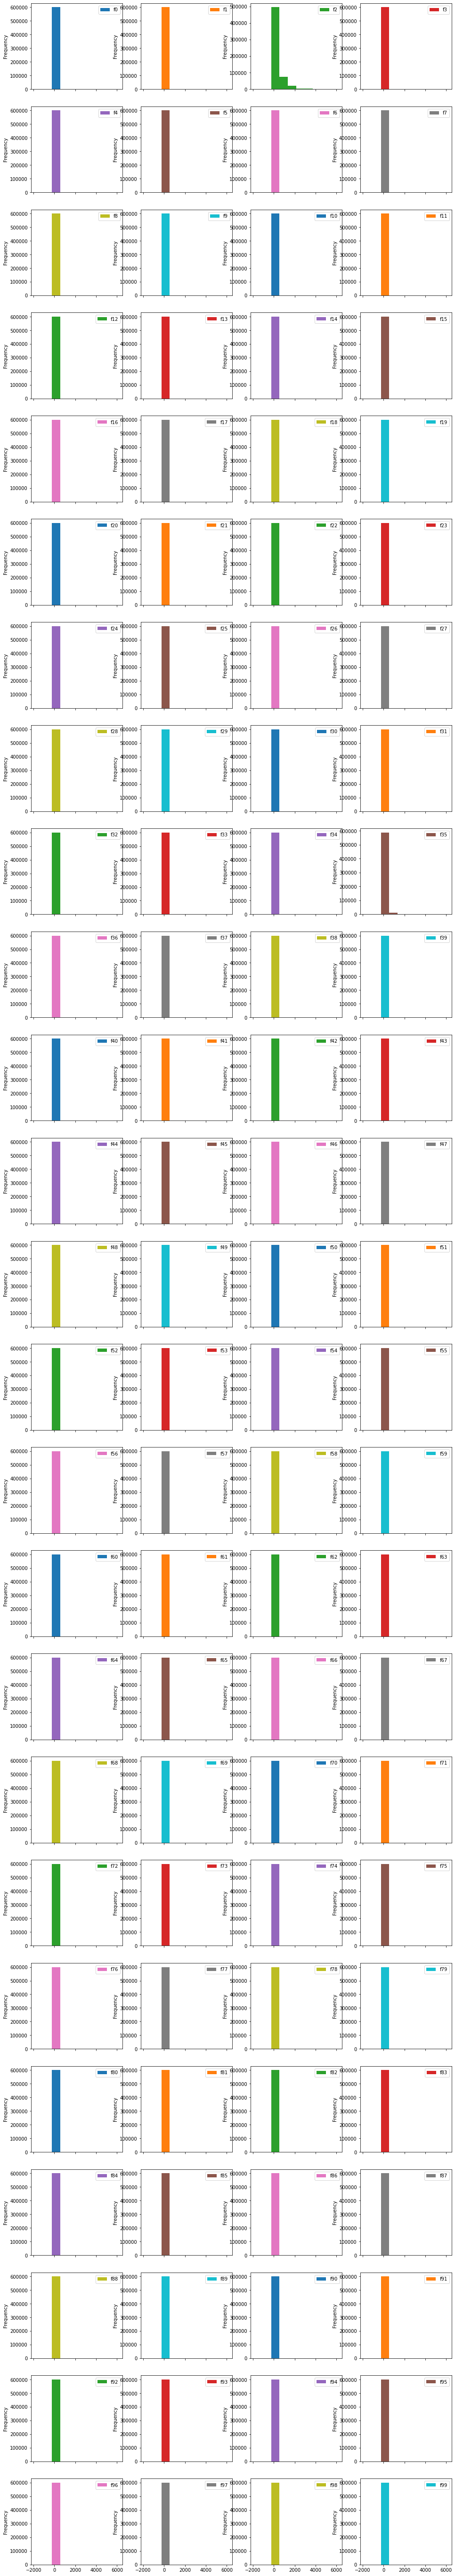

In [24]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

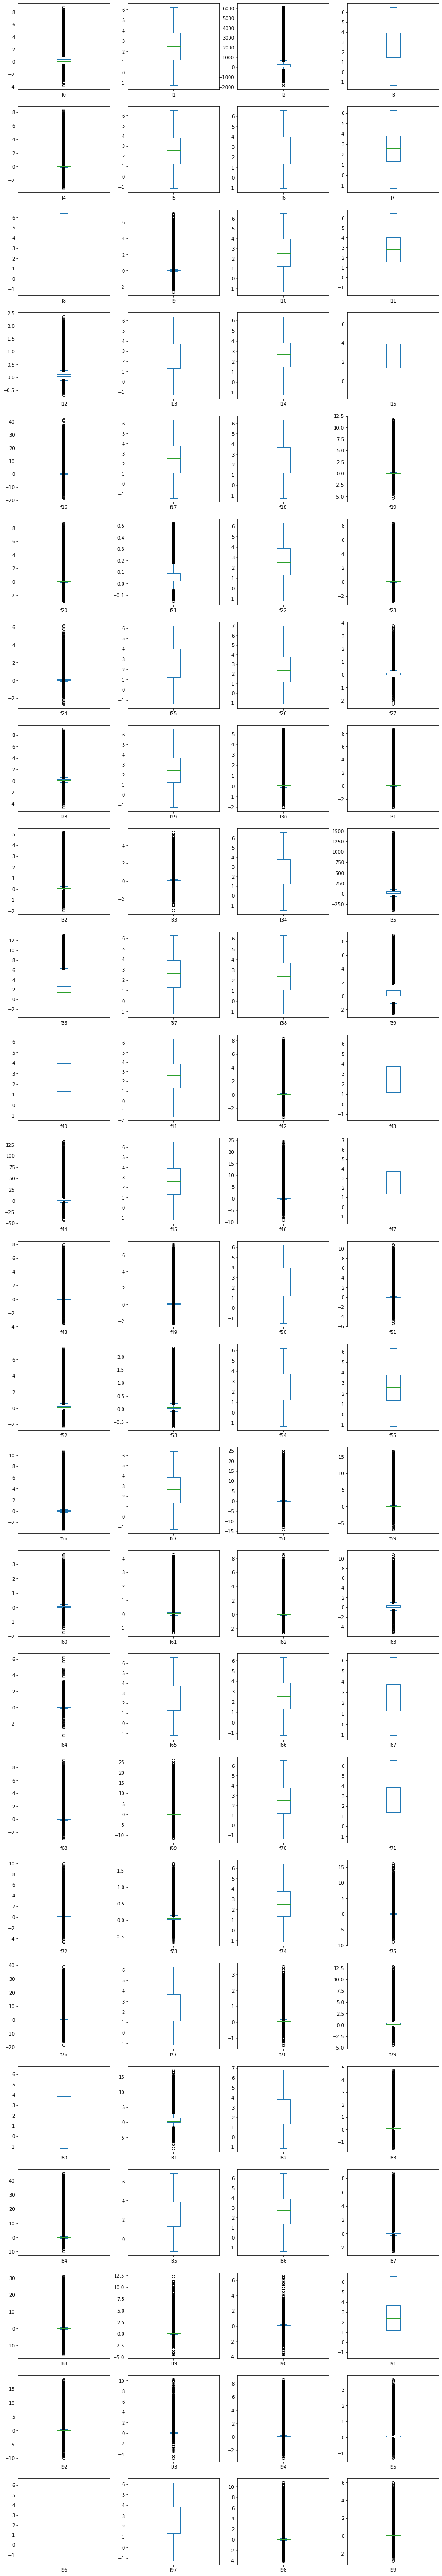

In [25]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

In [26]:
# # Correlation matrix
# fig = plt.figure(figsize=(20, 20))
# correlations = df_features_train.corr(method='pearson')
# sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
# plt.show()

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [28]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [29]:
# Split the data further into training and validation datasets
df_dataset_train, df_dataset_valid = train_test_split(df_dataset_import, test_size=VAL_SET_RATIO, random_state=RNG_SEED)
print("df_dataset_train.shape: {} df_dataset_valid.shape: {}".format(df_dataset_train.shape, df_dataset_valid.shape))

df_dataset_train.shape: (540000, 101) df_dataset_valid.shape: (60000, 101)


In [30]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_train, label='target', task=tfdf.keras.Task.CLASSIFICATION)
tfds_valid = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_valid, label='target', task=tfdf.keras.Task.CLASSIFICATION)

/home/pythonml/appdev/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1612: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


### 3.b) Train and Evaluate the Random Forest Model

In [31]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("TFDF Random Forest modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
model_1 = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
model_1.compile(metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_1.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')
if NOTIFY_STATUS: status_notify("TFDF Random Forest modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

8437/8438 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 8438
[INFO kernel.cc:393] Number of examples: 540000
[INFO kernel.cc:759] Dataset:
Number of records: 540000
Number of columns: 101

Number of columns by type:
	NUMERICAL: 100 (99.0099%)
	CATEGORICAL: 1 (0.990099%)

Columns:

NUMERICAL: 100 (99.0099%)
	0: "f0" NUMERICAL mean:0.30675 min:-3.79745 max:8.7815 sd:0.522401
	1: "f1" NUMERICAL mean:2.49642 min:-1.22396 max:6.22672 sd:1.55402
	2: "f10" NUMERICAL mean:2.58041 min:-1.30973 max:6.50876 sd:1.60409
	3: "f11" NUMERICAL mean:2.75858 min:-1.45157 max:6.45662 sd:1.54531
	4: "f12" NUMERICAL mean:0.129038 min:-0.678145 max:2.36123 sd:0.21099
	5: "f13" NUMERICAL mean:2.47622 min:-1.29516 max:6.40146 sd:1.51799
	6: "f14" NUMERICAL mean:2.66163 min:-1.21389 max:6.3692 sd:1.48176
	7: "f15" NUMERICAL mean:2.62969 min:-1.45054 max:6.77475 sd:1.53111
	8: "f16" NUMERICAL mean:0.362157 min:-18.1696 max:41.4692

8438/8438 [==============================] - 1908s 224ms/step
Model training time: 0:31:58.060900 



In [32]:
# tfdf.model_plotter.plot_model_in_colab(model_1)

In [33]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=540000, accuracy=0.6686092592592593, loss=0.6321490701861714, rmse=None, ndcg=None, aucs=None)

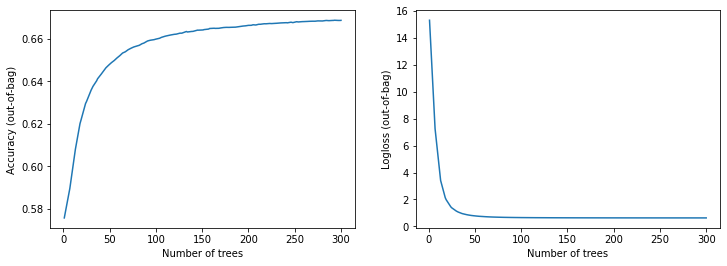

In [34]:
logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [35]:
evaluation = model_1.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

938/938 [==============================] - 36s 36ms/step - loss: 0.0000e+00 - accuracy: 0.6744 - auc: 0.7166

loss: 0.0000
accuracy: 0.6744
auc: 0.7166


### 3.c) Train and Evaluate the Decision Trees Model

In [36]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("TFDF Decision Trees modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
model_2 = tfdf.keras.CartModel(task=tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
model_2.compile(
    metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_2.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')
if NOTIFY_STATUS: status_notify("TFDF Decision Trees modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

8437/8438 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 8438
[INFO kernel.cc:393] Number of examples: 540000
[INFO kernel.cc:759] Dataset:
Number of records: 540000
Number of columns: 101

Number of columns by type:
	NUMERICAL: 100 (99.0099%)
	CATEGORICAL: 1 (0.990099%)

Columns:

NUMERICAL: 100 (99.0099%)
	0: "f0" NUMERICAL mean:0.30675 min:-3.79745 max:8.7815 sd:0.522401
	1: "f1" NUMERICAL mean:2.49642 min:-1.22396 max:6.22672 sd:1.55402
	2: "f10" NUMERICAL mean:2.58041 min:-1.30973 max:6.50876 sd:1.60409
	3: "f11" NUMERICAL mean:2.75858 min:-1.45157 max:6.45662 sd:1.54531
	4: "f12" NUMERICAL mean:0.129038 min:-0.678145 max:2.36123 sd:0.21099
	5: "f13" NUMERICAL mean:2.47622 min:-1.29516 max:6.40146 sd:1.51799
	6: "f14" NUMERICAL mean:2.66163 min:-1.21389 max:6.3692 sd:1.48176
	7: "f15" NUMERICAL mean:2.62969 min:-1.45054 max:6.77475 sd:1.53111
	8: "f16" NUMERICAL mean:0.362157 min:-18.1696 max:41.4692

8438/8438 [==============================] - 242s 28ms/step
Model training time: 0:04:04.333969 



In [37]:
# tfdf.model_plotter.plot_model_in_colab(model_2)

In [38]:
model_2.make_inspector().evaluation()

In [39]:
evaluation = model_2.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

938/938 [==============================] - 26s 26ms/step - loss: 0.0000e+00 - accuracy: 0.5945 - auc: 0.6713

loss: 0.0000
accuracy: 0.5945
auc: 0.6713


### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [40]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("TFDF Gradient Boosted Treees modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
model_3 = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
model_3.compile(metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_3.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')
if NOTIFY_STATUS: status_notify("TFDF Gradient Boosted Trees modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

8436/8438 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 8438
[INFO kernel.cc:393] Number of examples: 540000
[INFO kernel.cc:759] Dataset:
Number of records: 540000
Number of columns: 101

Number of columns by type:
	NUMERICAL: 100 (99.0099%)
	CATEGORICAL: 1 (0.990099%)

Columns:

NUMERICAL: 100 (99.0099%)
	0: "f0" NUMERICAL mean:0.30675 min:-3.79745 max:8.7815 sd:0.522401
	1: "f1" NUMERICAL mean:2.49642 min:-1.22396 max:6.22672 sd:1.55402
	2: "f10" NUMERICAL mean:2.58041 min:-1.30973 max:6.50876 sd:1.60409
	3: "f11" NUMERICAL mean:2.75858 min:-1.45157 max:6.45662 sd:1.54531
	4: "f12" NUMERICAL mean:0.129038 min:-0.678145 max:2.36123 sd:0.21099
	5: "f13" NUMERICAL mean:2.47622 min:-1.29516 max:6.40146 sd:1.51799
	6: "f14" NUMERICAL mean:2.66163 min:-1.21389 max:6.3692 sd:1.48176
	7: "f15" NUMERICAL mean:2.62969 min:-1.45054 max:6.77475 sd:1.53111
	8: "f16" NUMERICAL mean:0.362157 min:-18.1696 max:41.4692

8438/8438 [==============================] - 1755s 208ms/step
Model training time: 0:29:18.824714 



In [41]:
# tfdf.model_plotter.plot_model_in_colab(model_3)

In [42]:
model_3.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=0.7096393704414368, loss=1.2168961763381958, rmse=None, ndcg=None, aucs=None)

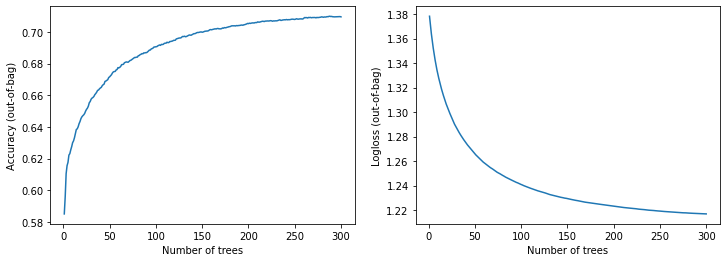

In [43]:
logs = model_3.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [44]:
evaluation = model_3.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

938/938 [==============================] - 29s 29ms/step - loss: 0.0000e+00 - accuracy: 0.7114 - auc: 0.6951

loss: 0.0000
accuracy: 0.7114
auc: 0.6951


In [45]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [46]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [47]:
for num_trees in [300, 500, 750, 1000]:
    # Define the baseline model for benchmarking
    start_time_module = datetime.now()
    model_tune = tfdf.keras.RandomForestModel(num_trees=num_trees, task=tfdf.keras.Task.CLASSIFICATION)

    # Optionally, add evaluation metrics.
    model_tune.compile(metrics=DEFAULT_METRICS)

    # Train the model.
    model_tune.fit(x=tfds_train, verbose=False)

    evaluation = model_tune.evaluate(tfds_valid, return_dict=True)
    print()

    for name, value in evaluation.items():
        print(f"{name}: {value:.4f}")
    print ('Model optimization time:', (datetime.now() - start_time_module), '\n')

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 8438
[INFO kernel.cc:393] Number of examples: 540000
[INFO kernel.cc:759] Dataset:
Number of records: 540000
Number of columns: 101

Number of columns by type:
	NUMERICAL: 100 (99.0099%)
	CATEGORICAL: 1 (0.990099%)

Columns:

NUMERICAL: 100 (99.0099%)
	0: "f0" NUMERICAL mean:0.30675 min:-3.79745 max:8.7815 sd:0.522401
	1: "f1" NUMERICAL mean:2.49642 min:-1.22396 max:6.22672 sd:1.55402
	2: "f10" NUMERICAL mean:2.58041 min:-1.30973 max:6.50876 sd:1.60409
	3: "f11" NUMERICAL mean:2.75858 min:-1.45157 max:6.45662 sd:1.54531
	4: "f12" NUMERICAL mean:0.129038 min:-0.678145 max:2.36123 sd:0.21099
	5: "f13" NUMERICAL mean:2.47622 min:-1.29516 max:6.40146 sd:1.51799
	6: "f14" NUMERICAL mean:2.66163 min:-1.21389 max:6.3692 sd:1.48176
	7: "f15" NUMERICAL mean:2.62969 min:-1.45054 max:6.77475 sd:1.53111
	8: "f16" NUMERICAL mean:0.362157 min:-18.1696 max:41.4692

938/938 [==============================] - 38s 38ms/step - loss: 0.0000e+00 - accuracy: 0.6744 - auc: 0.7008

loss: 0.0000
accuracy: 0.6744
auc: 0.7008
Model optimization time: 0:32:24.681869 



[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 8438
[INFO kernel.cc:393] Number of examples: 540000
[INFO kernel.cc:759] Dataset:
Number of records: 540000
Number of columns: 101

Number of columns by type:
	NUMERICAL: 100 (99.0099%)
	CATEGORICAL: 1 (0.990099%)

Columns:

NUMERICAL: 100 (99.0099%)
	0: "f0" NUMERICAL mean:0.30675 min:-3.79745 max:8.7815 sd:0.522401
	1: "f1" NUMERICAL mean:2.49642 min:-1.22396 max:6.22672 sd:1.55402
	2: "f10" NUMERICAL mean:2.58041 min:-1.30973 max:6.50876 sd:1.60409
	3: "f11" NUMERICAL mean:2.75858 min:-1.45157 max:6.45662 sd:1.54531
	4: "f12" NUMERICAL mean:0.129038 min:-0.678145 max:2.36123 sd:0.21099
	5: "f13" NUMERICAL mean:2.47622 min:-1.29516 max:6.40146 sd:1.51799
	6: "f14" NUMERICAL mean:2.66163 min:-1.21389 max:6.3692 sd:1.48176
	7: "f15" NUMERICAL mean:2.62969 min:-1.45054 max:6.77475 sd:1.53111
	8: "f16" NUMERICAL mean:0.362157 min:-18.1696 max:41.4692

938/938 [==============================] - 40s 41ms/step - loss: 0.0000e+00 - accuracy: 0.6761 - auc: 0.7042

loss: 0.0000
accuracy: 0.6761
auc: 0.7042
Model optimization time: 0:50:32.466991 



[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 8438
[INFO kernel.cc:393] Number of examples: 540000
[INFO kernel.cc:759] Dataset:
Number of records: 540000
Number of columns: 101

Number of columns by type:
	NUMERICAL: 100 (99.0099%)
	CATEGORICAL: 1 (0.990099%)

Columns:

NUMERICAL: 100 (99.0099%)
	0: "f0" NUMERICAL mean:0.30675 min:-3.79745 max:8.7815 sd:0.522401
	1: "f1" NUMERICAL mean:2.49642 min:-1.22396 max:6.22672 sd:1.55402
	2: "f10" NUMERICAL mean:2.58041 min:-1.30973 max:6.50876 sd:1.60409
	3: "f11" NUMERICAL mean:2.75858 min:-1.45157 max:6.45662 sd:1.54531
	4: "f12" NUMERICAL mean:0.129038 min:-0.678145 max:2.36123 sd:0.21099
	5: "f13" NUMERICAL mean:2.47622 min:-1.29516 max:6.40146 sd:1.51799
	6: "f14" NUMERICAL mean:2.66163 min:-1.21389 max:6.3692 sd:1.48176
	7: "f15" NUMERICAL mean:2.62969 min:-1.45054 max:6.77475 sd:1.53111
	8: "f16" NUMERICAL mean:0.362157 min:-18.1696 max:41.4692

938/938 [==============================] - 48s 49ms/step - loss: 0.0000e+00 - accuracy: 0.6761 - auc: 0.7065

loss: 0.0000
accuracy: 0.6761
auc: 0.7065
Model optimization time: 1:14:21.750088 



[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 8438
[INFO kernel.cc:393] Number of examples: 540000
[INFO kernel.cc:759] Dataset:
Number of records: 540000
Number of columns: 101

Number of columns by type:
	NUMERICAL: 100 (99.0099%)
	CATEGORICAL: 1 (0.990099%)

Columns:

NUMERICAL: 100 (99.0099%)
	0: "f0" NUMERICAL mean:0.30675 min:-3.79745 max:8.7815 sd:0.522401
	1: "f1" NUMERICAL mean:2.49642 min:-1.22396 max:6.22672 sd:1.55402
	2: "f10" NUMERICAL mean:2.58041 min:-1.30973 max:6.50876 sd:1.60409
	3: "f11" NUMERICAL mean:2.75858 min:-1.45157 max:6.45662 sd:1.54531
	4: "f12" NUMERICAL mean:0.129038 min:-0.678145 max:2.36123 sd:0.21099
	5: "f13" NUMERICAL mean:2.47622 min:-1.29516 max:6.40146 sd:1.51799
	6: "f14" NUMERICAL mean:2.66163 min:-1.21389 max:6.3692 sd:1.48176
	7: "f15" NUMERICAL mean:2.62969 min:-1.45054 max:6.77475 sd:1.53111
	8: "f16" NUMERICAL mean:0.362157 min:-18.1696 max:41.4692

938/938 [==============================] - 53s 55ms/step - loss: 0.0000e+00 - accuracy: 0.6760 - auc: 0.7082

loss: 0.0000
accuracy: 0.6760
auc: 0.7082
Model optimization time: 1:36:06.652044 



In [48]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [49]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [50]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_import, label='target')

In [51]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("The final TFDF model training has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
final_model = tfdf.keras.RandomForestModel(num_trees=1000, task=tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
final_model.compile(metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')
if NOTIFY_STATUS: status_notify("The final TFDF model training completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

9373/9375 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 9375
[INFO kernel.cc:393] Number of examples: 600000
[INFO kernel.cc:759] Dataset:
Number of records: 600000
Number of columns: 101

Number of columns by type:
	NUMERICAL: 100 (99.0099%)
	CATEGORICAL: 1 (0.990099%)

Columns:

NUMERICAL: 100 (99.0099%)
	0: "f0" NUMERICAL mean:0.306508 min:-3.79745 max:8.7815 sd:0.522449
	1: "f1" NUMERICAL mean:2.49759 min:-1.22396 max:6.22672 sd:1.55402
	2: "f10" NUMERICAL mean:2.57999 min:-1.30973 max:6.50876 sd:1.60439
	3: "f11" NUMERICAL mean:2.75927 min:-1.45157 max:6.45662 sd:1.54522
	4: "f12" NUMERICAL mean:0.128958 min:-0.678145 max:2.36123 sd:0.210861
	5: "f13" NUMERICAL mean:2.47724 min:-1.29516 max:6.40146 sd:1.51769
	6: "f14" NUMERICAL mean:2.66286 min:-1.21389 max:6.3692 sd:1.48197
	7: "f15" NUMERICAL mean:2.63104 min:-1.45054 max:6.77475 sd:1.53107
	8: "f16" NUMERICAL mean:0.362479 min:-18.1696 max:41.46

9375/9375 [==============================] - 6320s 674ms/step
Model training time: 1:45:26.843895 



In [52]:
final_model.summary()

Model: "random_forest_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (100):
	f0
	f1
	f10
	f11
	f12
	f13
	f14
	f15
	f16
	f17
	f18
	f19
	f2
	f20
	f21
	f22
	f23
	f24
	f25
	f26
	f27
	f28
	f29
	f3
	f30
	f31
	f32
	f33
	f34
	f35
	f36
	f37
	f38
	f39
	f4
	f40
	f41
	f42
	f43
	f44
	f45
	f46
	f47
	f48
	f49
	f5
	f50
	f51
	f52
	f53
	f54
	f55
	f56
	f57
	f58
	f59
	f6
	f60
	f61
	f62
	f63
	f64
	f65
	f66
	f67
	f68
	f69
	f7
	f70
	f71
	f72
	f73
	f74
	f75
	f76
	f77
	f78
	f79
	f8
	f80
	f81
	f82
	f83
	f84
	f85
	f86
	f87
	f88
	f89
	f9
	f90
	f91
	f92
	f93
	f94
	f95
	f96
	f97
	f98
	f99

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1. "__LABEL" 14.233286 ################
    2.     "f52" 14.096680 ###############
 

In [53]:
# tfdf.model_plotter.plot_model_in_colab(final_model)

In [54]:
final_model.make_inspector().evaluation()

Evaluation(num_examples=600000, accuracy=0.6730233333333333, loss=0.6289367722033027, rmse=None, ndcg=None, aucs=None)

In [55]:
evaluation = final_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

938/938 [==============================] - 52s 54ms/step - loss: 0.0000e+00 - accuracy: 0.7945 - auc: 0.7306

loss: 0.0000
accuracy: 0.7945
auc: 0.7306


### 5.b) Load Test Dataset and Prepare the Submission File

In [56]:
if not os.path.exists(TEST_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021nov/test.csv

--2021-12-03 06:34:29--  https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021nov/test.csv
Resolving dainesanalytics.com (dainesanalytics.com)... 13.225.142.25, 13.225.142.96, 13.225.142.69, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.225.142.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 490019449 (467M) [text/csv]
Saving to: ‘test.csv’

test.csv            100%[===================>] 467.32M  4.81MB/s    in 1m 45s  

2021-12-03 06:36:14 (4.46 MB/s) - ‘test.csv’ saved [490019449/490019449]



In [57]:
df_features_test = pd.read_csv(TEST_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

       id        f0        f1       f2        f3        f4        f5  \
0  600000  0.003229  4.838660  585.529  2.282910  0.713180  3.907830   
1  600001  0.008602  0.505536 -100.099  3.012670  0.027199  1.194610   
2  600002  1.461000  2.437260 -112.964  3.541230  0.752338  4.338310   
3  600003  0.140556  3.085610  179.451  0.573945  0.057342  2.216790   
4  600004  0.128876  5.199760  107.466 -0.497149  0.080220  0.458121   

         f6        f7        f8  ...       f90       f91       f92       f93  \
0  0.480696  1.482270  4.891810  ...  0.112910  1.073550  0.122149  0.086330   
1  5.036620  2.517440  4.553890  ... -0.020214  2.622340  0.123307  0.033063   
2  1.648080  4.699910  1.950250  ... -0.011036  2.030180 -0.000426  0.084091   
3  1.623480  0.526174  1.542540  ...  0.050117  0.221613  0.045298  0.129966   
4  0.629839  5.240460 -0.232279  ...  0.058860  2.660430  0.135425  0.036481   

        f94       f95       f96       f97       f98       f99  
0  0.036010  0.010619 

In [58]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

       id
0  600000
1  600001
2  600002
3  600003
4  600004


In [59]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

         f0        f1       f2        f3        f4        f5        f6  \
0  0.003229  4.838660  585.529  2.282910  0.713180  3.907830  0.480696   
1  0.008602  0.505536 -100.099  3.012670  0.027199  1.194610  5.036620   
2  1.461000  2.437260 -112.964  3.541230  0.752338  4.338310  1.648080   
3  0.140556  3.085610  179.451  0.573945  0.057342  2.216790  1.623480   
4  0.128876  5.199760  107.466 -0.497149  0.080220  0.458121  0.629839   

         f7        f8        f9  ...       f90       f91       f92       f93  \
0  1.482270  4.891810  0.056351  ...  0.112910  1.073550  0.122149  0.086330   
1  2.517440  4.553890  0.063876  ... -0.020214  2.622340  0.123307  0.033063   
2  4.699910  1.950250  0.005303  ... -0.011036  2.030180 -0.000426  0.084091   
3  0.526174  1.542540 -0.026160  ...  0.050117  0.221613  0.045298  0.129966   
4  5.240460 -0.232279  0.030006  ...  0.058860  2.660430  0.135425  0.036481   

        f94       f95       f96       f97       f98       f99  
0  0.03601

In [60]:
# Finalize the test dataset for the prediction activities
tfds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_features_test)

In [61]:
# Make batched predictions
test_predictions = final_model.predict(tfds_test)
print(test_predictions)

[[0.73099416]
 [0.76399374]
 [0.83199286]
 ...
 [0.36499885]
 [0.59999585]
 [0.71699435]]


In [62]:
df_kaggle_submission['target'] = test_predictions
print(df_kaggle_submission.head())

       id    target
0  600000  0.730994
1  600001  0.763994
2  600002  0.831993
3  600003  0.640995
4  600004  0.545997


In [63]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20211203-0644.csv


In [64]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [65]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 8:06:53.197683
